# Instructions

Install the environment required for this notebook using the environment file `environment_minimal.yml` and enter the created environment.

Then start the notebook from the project directory.
The directory should contain at least:
```
Project 4
├── data
│   ├── mitbih_test.csv
│   ├── mitbih_train.csv
│   ├── ptbdb_abnormal.csv
│   └── ptbdb_normal.csv
├── saved_weights
│   ├── baseline_cnn_mitbih.h5
│   ├── baseline_cnn_ptbdb.h5
│   ├── baseline_with_fourier.h5
│   ├── baseline_with_fourier_ptbdb.h5
│   ├── ...
```

If you want to check our results without retraining the largest models, in the next cell set `ALLOW_TRAINING = False`.
If you want to retrain the models, use `ALLOW_TRAINING = True`.

In [1]:
ALLOW_TRAINING = False

# Imports

In [81]:
# #Google Colab Setup Moritz
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/Project_4')
# print("Current Working Directory " , os.getcwd())

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from sklearn.metrics import f1_score, accuracy_score, average_precision_score, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt

import focal_loss

!pip install -q -U keras-tuner
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

# Utility

This section includes constants and functions which are useful throughout the notebook.

In [4]:
# The code in used to replace the ambigous padding of the original data
PADDING_VALUE = -1

def replace_zero_padding(X):
  X = X.copy()
  indexes = np.arange(X.shape[1])
  for sample_idx, sample in enumerate(X):
    t = sample[:, 0] != 0
    seq_length = 1 + np.max(indexes[t])
    sample[seq_length:] = PADDING_VALUE
  return X

In [5]:
# Ensemble methods
class Ensemble:
  def __init__(self, models):
    assert len(models) >= 1
    self._models = models

  def _get_prediction_tensor(self, Xs):
    pred = [model.predict(X) for model, X in zip(self._models, Xs)]
    return np.stack(pred, axis=2)

class VotingEnsemble(Ensemble):
  def __init__(self, models, voting="soft"):
    super().__init__(models)

    assert voting in ["soft", "hard"]
    self._voting = voting

  def _get_prediction_tensor(self, Xs):
    pred_tensor = super()._get_prediction_tensor(Xs)

    if self._voting =="hard":
      n_classes = pred_tensor.shape[1]
      if n_classes == 1:
        pred_tensor = np.round(pred_tensor)
      else:
        max_pred = pred_tensor.max(axis=1, keepdims=True)
        pred_tensor = (pred_tensor == max_pred).astype(np.float)
        pred_tensor /= pred_tensor.sum(axis=1, keepdims=True) # break ties

    return pred_tensor

  def predict(self, Xs):
    return self._get_prediction_tensor(Xs).mean(axis=-1)

class LogisticEnsemble(Ensemble):
  """Uses logistic regression on the output of the ensemble model to predict results.
  """

  def __init__(self, models):
    super().__init__(models)
    self._logistic_regressor = None

  def _init_regressor(self, n_classes):
    if self._logistic_regressor is None:
      self._logistic_regressor = tf.keras.Sequential()
      self._logistic_regressor.add(tf.keras.layers.Flatten())
      if n_classes == 1:
        self._logistic_regressor.add(tf.keras.layers.Dense(n_classes, activation="sigmoid"))
        loss = tf.keras.losses.binary_crossentropy
      else:
        self._logistic_regressor.add(tf.keras.layers.Dense(n_classes, activation="softmax"))
        loss = tf.keras.losses.sparse_categorical_crossentropy
        
      opt = tf.keras.optimizers.Adam(0.001)
      self._logistic_regressor.compile(optimizer=opt, loss=loss,metrics=['acc'])

  def fit(self, Xs, Y):
    X = self._get_prediction_tensor(Xs)
    n_classes = X.shape[1]
    self._init_regressor(n_classes)

    file_path = os.path.join("saved_weights", "ensemble_lr.h5")
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    self._logistic_regressor.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    self._logistic_regressor.load_weights(file_path)
  
  def predict(self, Xs):
    X = self._get_prediction_tensor(Xs)
    return self._logistic_regressor.predict(X)

# Dataset 1: Arrhythmia Dataset

In this section we solve task 1, 2, and 3 on the Arrhythmia Dataset.

In [82]:
df_train = pd.read_csv("data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]
X_masked = replace_zero_padding(X)

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]
X_test_masked = replace_zero_padding(X_test)

In [83]:
def evaluate_model_dataset1(model, test_data=X_test):
  pred_test = model.predict(test_data)
  pred_test = np.argmax(pred_test, axis=-1)

  f1 = f1_score(Y_test, pred_test, average="macro")

  print("Test f1 score : %s "% f1)

  acc = accuracy_score(Y_test, pred_test)

  print("Test accuracy score : %s "% acc)

  return acc

## Data exploration

Plot the histogram of the length of the sequences.

Text(0.5, 1.0, 'Sequence lengths')

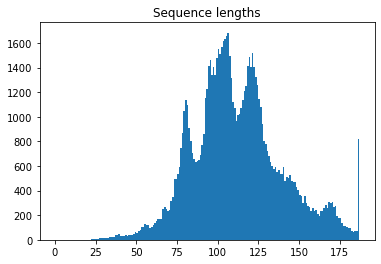

In [8]:
def signal_lengths(X):
  indexes = np.arange(X.shape[1])
  lengths = []
  for sample in X:
    seq_length = np.count_nonzero(sample != PADDING_VALUE)
    lengths.append(seq_length)
  return lengths

plt.hist(signal_lengths(X_masked), bins=np.arange(188))
plt.title("Sequence lengths")

Plot the distribution of the labels.

Text(0.5, 1.0, 'Label frequencey in the training set')

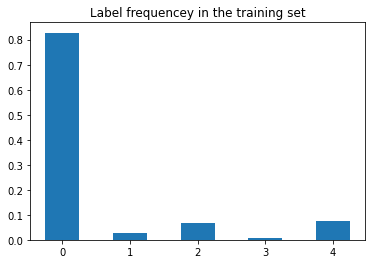

In [9]:
plt.hist(Y, bins=np.arange(6)-0.5, rwidth=0.5, density=True)
plt.title("Label frequencey in the training set")

Plot a sample of sequences.

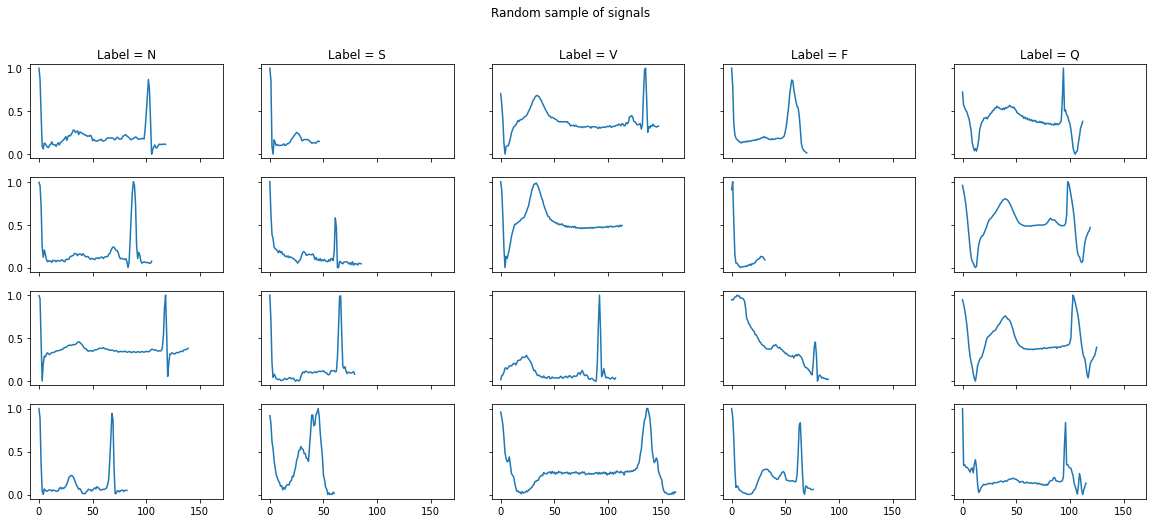

In [10]:
label_to_kw = ["N", "S", "V", "F", "Q"]
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(20,8))
fig.suptitle("Random sample of signals")
for i, row in enumerate(axes):
  for label, ax in enumerate(row):
    sample_idx = np.random.choice(np.flatnonzero(Y == label))
    sample = X_masked[sample_idx, :, 0]
    sample = sample[sample != PADDING_VALUE]
    ax.plot(sample)
    if i == 0:
      ax.set_title(f"Label = {label_to_kw[Y[sample_idx]]}")

## Baseline model

Initialize the model.

In [11]:
def get_baseline_mitbih():
    nclass = 5
    inp = tf.keras.layers.Input(shape=(187, 1))
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=tf.keras.activations.relu, padding="valid")(inp)
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(256, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(256, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.GlobalMaxPool1D()(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.2)(img_1)

    dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, name="dense_1")(img_1)
    dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, name="dense_2")(dense_1)
    dense_1 = tf.keras.layers.Dense(nclass, activation=tf.keras.activations.softmax, name="dense_3_mitbih")(dense_1)

    model = tf.keras.models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
    return model

baseline_mitbih = get_baseline_mitbih()
baseline_mitbih.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 16)           96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 89, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 87, 32)            1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 85, 32)            3104  

Train the model.

In [12]:
file_path = os.path.join("saved_weights", "baseline_cnn_mitbih.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

if ALLOW_TRAINING:
  baseline_mitbih.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
else:
  print("Training disabled.")
baseline_mitbih.load_weights(file_path)

Training disabled.


Evaluate the model.

In [13]:
_ = evaluate_model_dataset1(baseline_mitbih)

Test f1 score : 0.9120519331690315 
Test accuracy score : 0.9841494609903161 


## Task 1: Vanilla models

### Vanilla MLP

This baseline is simpler than the one we received and better displays the difficulty of the problem.

In [14]:
simple_baseline = tf.keras.Sequential([tf.keras.layers.Input(shape=(187,1)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256, activation="relu"),
                             tf.keras.layers.Dense(5, activation="softmax")
                            ])

opt = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
simple_baseline.compile(optimizer=opt,loss=loss,metrics='acc')
simple_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 187)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               48128     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 49,413
Trainable params: 49,413
Non-trainable params: 0
_________________________________________________________________


In [15]:
file_path = os.path.join("saved_weights", "simple_baseline.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

if ALLOW_TRAINING:
  simple_baseline.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
else:
  print("Training disabled.")
simple_baseline.load_weights(file_path)

Training disabled.


In [16]:
_ = evaluate_model_dataset1(simple_baseline, test_data=X_test)

Test f1 score : 0.8907386930011677 
Test accuracy score : 0.9794445459528595 


### Vanilla CNN

Initialize the model.

In [17]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, AvgPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate

# Takes about 4 Hours

def vanilla_CNN(hp):
    nclass = 5
    inp = Input(shape=(187, 1))
    hp_kernel1 = hp.Int('kernel1', min_value=5, max_value=7,step=2)
    img_1 = Convolution1D(16, kernel_size=hp_kernel1, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=hp_kernel1, activation=activations.relu, padding="valid")(img_1)
    hp_pooling1 = hp.Choice('pooling1', ['max'])
    if hp_pooling1 == 'max':
      img_1 = MaxPool1D(pool_size=2,data_format='channels_first')(img_1)
    else:
      img_1 = AvgPool1D(pool_size=2,data_format='channels_first')(img_1)
    hp_dropout1 = hp.Float('dropout1', min_value=0, max_value=0.2, step = 0.1)
    img_1 = Dropout(rate=hp_dropout1)(img_1)
    hp_kernel2 = hp.Int('kernel2', min_value=3, max_value=5,step=2)
    hp_dropout2 = hp.Float('dropout2', min_value=0, max_value=0.2, step = 0.1)
    hp_nlayers = hp.Int('num_layers', 0, 2)
    hp_pooling2 = hp.Choice('pooling2', ['max'])
    
    for i in range(hp_nlayers):

        img_1 = Convolution1D((i+1)*32, kernel_size=hp_kernel2, activation=activations.relu, padding="valid")(img_1)
        img_1 = Convolution1D((i+1)*32, kernel_size=hp_kernel2, activation=activations.relu, padding="valid")(img_1)
        tf.shape(img_1)
        if hp_pooling2 == 'max':
          img_1 = MaxPool1D(pool_size=2,data_format='channels_first')(img_1)
          tf.shape(img_1)
        else:
          img_1 = AvgPool1D(pool_size=2,data_format='channels_first')(img_1)

        img_1 = Dropout(rate=hp_dropout2)(img_1)

    img_1 = Convolution1D(32*(1+hp_nlayers), kernel_size=hp_kernel2, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32*(1+hp_nlayers), kernel_size=hp_kernel2, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    hp_dropout3 = hp.Float('dropout3', min_value=0, max_value=0.2, step=0.1)
    img_1 = Dropout(rate=hp_dropout3)(img_1)


    hp_dense1 = hp.Int('dense1', min_value=128, max_value=512, step=64)
    hp_dense2 = hp.Int('dense2', min_value=32, max_value=256, step=32)
    dense_1 = Dense(hp_dense1, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(hp_dense2, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3])
    opt = optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    return model

    
tuner = kt.tuners.bayesian.BayesianOptimization(vanilla_CNN,
                     objective='val_acc',
                     seed=1,
                     num_initial_points = 5,
                     max_trials=25,
                     overwrite=True
                     )

if ALLOW_TRAINING:
  stop_early = EarlyStopping(monitor='val_acc', patience=5,mode='max',verbose=1)
  tuner.search(X, Y, epochs=25, validation_split=0.1, callbacks=[stop_early])
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  
else:
  print("Training disabled.")
  print("Best hyperparameters obtained by previous run.")
  best_hps = kt.HyperParameters()
  best_hps.Fixed("kernel1", 5)
  best_hps.Fixed("pooling1", "max")
  best_hps.Fixed("dropout1", 0)
  best_hps.Fixed("kernel2", 5)
  best_hps.Fixed("dropout2", 0)
  best_hps.Fixed("num_layers", 1)
  best_hps.Fixed("pooling2", "max")
  best_hps.Fixed("dropout3", 0.1)
  best_hps.Fixed("dense1", 512)
  best_hps.Fixed("dense2", 256)
  best_hps.Fixed("learning_rate", 1e-3)

print(f"""
The hyperparameter search is complete. The optimal kernel sizes are:
{best_hps.get('kernel1')}, {best_hps.get('kernel2')}
The optimal rate of dropout are: 
{best_hps.get('dropout1')}, {best_hps.get('dropout2')}, {best_hps.get('dropout3')}
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
We use the following Poolings:
{best_hps.get('pooling1')}, {best_hps.get('pooling2')}
The dense layers have the following optimal sizes:
{best_hps.get('dense1')}, {best_hps.get('dense2')}
We use {best_hps.get('num_layers')} + 1 convolutional layers.
""")

Training disabled.
Best hyperparameters obtained by previous run.

The hyperparameter search is complete. The optimal kernel sizes are:
5, 5
The optimal rate of dropout are: 
0, 0, 0.1
The optimal learning rate for the optimizer is 0.001.
We use the following Poolings:
max, max
The dense layers have the following optimal sizes:
512, 256
We use 1 + 1 convolutional layers.



Train the model.

In [18]:
vanilla_CNN = tuner.hypermodel.build(best_hps)
vanilla_CNN.summary()

file_path = os.path.join("saved_weights", "vanilla_cnn_mitbih.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
callbacks_list = [checkpoint, early]  # early

if ALLOW_TRAINING:
  vanilla_CNN.fit(X, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1)
else:
  print("Training disabled.")
vanilla_CNN.load_weights(file_path)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 16)           96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 179, 8)            0         
_________________________________________________________________
dropout (Dropout)            (None, 179, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 175, 32)           1312      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 171, 32)           5152  

Evaluate the model.

In [19]:
_ = evaluate_model_dataset1(vanilla_CNN, test_data=X_test)

Test f1 score : 0.8617189535097435 
Test accuracy score : 0.9730038370180888 


### Vanilla RNN

Initialize the model.

In [85]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, AvgPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from tensorflow.keras.layers import SimpleRNN, LSTM, Masking, Bidirectional

def get_vanilla_RNN():
    nclass = 5
    inp = Input(shape=(187, 1))
    masked = Masking(mask_value=PADDING_VALUE)(inp)
    hidden_1 = SimpleRNN(128)(masked)

    dense_1 = Dense(256, activation=activations.relu, name="dense_1")(hidden_1)
    dense_1 = Dropout(rate=0.1)(dense_1)
    dense_1 = Dense(128, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dropout(rate=0.1)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    return model

vanilla_RNN = get_vanilla_RNN()
vanilla_RNN.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
masking_2 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0   

Train the model.

In [86]:
file_path = os.path.join("saved_weights", "vanilla_rnn_mitbih.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
callbacks_list = [checkpoint, early]  # early

if ALLOW_TRAINING:
  vanilla_RNN.fit(X_masked, Y, epochs=1000, verbose=1, callbacks=[callbacks_list], validation_split=0.1)
else:
  print("Training disabled.")
vanilla_RNN.load_weights(file_path)

Training disabled.


Evaluate the model.

In [87]:
_ = evaluate_model_dataset1(vanilla_RNN, test_data=X_test_masked)

Test f1 score : 0.807973525179551 
Test accuracy score : 0.9608076009501187 


## Task 2: Creative models

### Fourier transform based model

In [89]:
def to_fourier(X):  
  outputs = []
  for x in tqdm(X[:,:,0]):
    x = x.copy()
    x[x == PADDING_VALUE] = 0.5 # set a value which should be near the mean
    transformed = tf.signal.rfft(x).numpy()
    real_imag = np.stack([np.real(transformed),
                          np.imag(transformed),
                          ]).T
    outputs.append(real_imag)
  print() # tqdm doesn't do a new line
  return np.stack(outputs)

X_fourier = to_fourier(X)
X_test_fourier = to_fourier(X_test)

  0%|                                                                                                            | 0/21892 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 21892/21892 [00:10<00:00, 2106.38it/s]

In [24]:
def get_baseline_mitbih_fourier():
    nclass = 5
    inp = tf.keras.layers.Input(shape=(94, 2))
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=tf.keras.activations.relu, padding="valid")(inp)
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(256, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(256, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.GlobalMaxPool1D()(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.2)(img_1)

    dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, name="dense_1")(img_1)
    dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, name="dense_2")(dense_1)
    dense_1 = tf.keras.layers.Dense(nclass, activation=tf.keras.activations.softmax, name="dense_3_mitbih")(dense_1)

    model = tf.keras.models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
    return model

baseline_mitbih_fourier = get_baseline_mitbih_fourier()
baseline_mitbih_fourier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 94, 2)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 90, 16)            176       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 86, 16)            1296      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 43, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 43, 16)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 41, 32)            1568      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 39, 32)            3104

In [25]:
file_path = os.path.join("saved_weights", "baseline_with_fourier.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

if ALLOW_TRAINING:
  baseline_mitbih_fourier.fit(X_fourier, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
else:
  print("Training disabled.")
baseline_mitbih_fourier.load_weights(file_path)

Training disabled.


In [26]:
_ = evaluate_model_dataset1(baseline_mitbih_fourier, test_data=X_test_fourier)

Test f1 score : 0.7143362107072828 
Test accuracy score : 0.9285583774894939 


### CNN with Residual Blocks (aka Resnet)

The code in the following cell is adapted from ResNet V2's [github repository](https://github.com/KaimingHe/resnet-1k-layers).

In [27]:
def get_residual_unit(output_filters, stride):
  def residual_unit(inputs):
    n_bottleneck = output_filters // 4

    # conv 1x1
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.ReLU()(x)

    if inputs.shape[-1] == output_filters:
      shortcut = inputs
    else:
      shortcut = tf.keras.layers.Conv1D(output_filters, 1, stride, "same")(x)

    x = tf.keras.layers.Conv1D(n_bottleneck, 1, stride, "same")(x)

    # conv 3x3
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(n_bottleneck, 3, 1, "same")(x)

    # conv 1x1
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(output_filters, 1, 1, "same")(x)

    x = tf.keras.layers.Add()([shortcut, x])

    return x

  return residual_unit

def get_resnet_stage(output_filters, count, stride, name):
  def resnet_stage(inputs):
    x = get_residual_unit(output_filters, stride)(inputs)

    for i in range(count - 1):
      x = get_residual_unit(output_filters, 1)(x)
    
    return x

  return resnet_stage

def get_resnet(depth):
  assert (depth - 2) % 9 == 0
  n = (depth - 2) // 9

  stage_filters = [16, 64, 128, 256]

  # Stage 0
  inputs = tf.keras.layers.Input(shape=(187, 1))
  x = tf.keras.layers.Conv1D(stage_filters[0], 7, 1, "same")(inputs)
  x = get_resnet_stage(stage_filters[1], n, 1, "stage_1")(x)
  x = get_resnet_stage(stage_filters[2], n, 2, "stage_2")(x)
  x = get_resnet_stage(stage_filters[3], n, 2, "stage_3")(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  x = tf.keras.layers.Dense(5, activation="softmax")(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  opt = tf.keras.optimizers.Adam(0.001)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()

  model.compile(optimizer=opt,loss=loss,metrics='acc')
  return model


resnet = get_resnet(398)
resnet.summary()
# tf.keras.utils.plot_model(resnet, show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 187, 16)      128         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 187, 16)      64          conv1d_14[0][0]                  
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 187, 16)      0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [28]:
# We use the masked dataset because we used it during training by mistake
file_path = os.path.join("saved_weights", "resnet.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

if ALLOW_TRAINING:
  resnet.fit(X_masked, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1, batch_size=128)
else:
  print("Training disabled.")
resnet.load_weights(file_path)

Training disabled.


In [29]:
_ = evaluate_model_dataset1(resnet, test_data=X_test_masked)

Test f1 score : 0.9322596897066806 
Test accuracy score : 0.9886259820939156 


### Bidirectional LSTM

In [30]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, AvgPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from tensorflow.keras.layers import SimpleRNN, LSTM, Masking, Bidirectional

def get_bidirectional_lstm():
    nclass = 5
    inp = Input(shape=(187, 1))
    masked = Masking(mask_value=PADDING_VALUE)(inp)
    hidden_1 = Bidirectional(LSTM(128))(masked)

    dense_1 = Dense(256, activation=activations.relu)(hidden_1)
    dense_1 = Dropout(rate=0.1)(dense_1)
    dense_1 = Dense(128, activation=activations.relu)(dense_1)
    dense_1 = Dropout(rate=0.1)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    return model

bidirectional_lstm = get_bidirectional_lstm()
bidirectional_lstm.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
masking_1 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               133120    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0   

In [31]:
file_path = os.path.join("saved_weights", "bidirectional_lstm.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early


if ALLOW_TRAINING:
  bidirectional_lstm.fit(X_masked, Y, epochs=1000, verbose=1, callbacks=[callbacks_list], validation_split=0.1)
else:
  print("Training disabled.")
bidirectional_lstm.load_weights(file_path)

Training disabled.


In [32]:
_ = evaluate_model_dataset1(bidirectional_lstm, test_data=X_test_masked)

Test f1 score : 0.9074508327762401 
Test accuracy score : 0.9836926731226019 


### CNN + Bidirectional LSTM Model 

In [33]:
def get_cnn_bi_lstm():
    nclass = 5
    inp = tf.keras.layers.Input(shape=(187, 1))

    conv = tf.keras.layers.Conv1D(filters=200, kernel_size=3, dilation_rate=2, activation="relu")(inp)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(rate=0.05)(conv)

    conv = tf.keras.layers.Conv1D(filters=150, kernel_size=3, dilation_rate=2, activation="relu")(conv)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(rate=0.05)(conv)

    conv = tf.keras.layers.Conv1D(filters=100, kernel_size=3, dilation_rate=2, activation="relu")(conv)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(rate=0.05)(conv)

    conv = tf.keras.layers.Conv1D(filters=75, kernel_size=3, dilation_rate=2, activation="relu")(conv)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(rate=0.05)(conv)


    hidden_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True))(conv)

    dense_1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(hidden_1)
    dense_1 = tf.keras.layers.Dropout(rate=0.3)(dense_1)
    dense_1 = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)(dense_1)
    dense_1 = tf.keras.layers.Dropout(rate=0.3)(dense_1)
    dense_1 = tf.keras.layers.Flatten()(dense_1)
    dense_1 = tf.keras.layers.Dense(nclass, activation=tf.keras.activations.softmax)(dense_1)

    modeltt = tf.keras.models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    modeltt.compile(optimizer=opt, loss=focal_loss.SparseCategoricalFocalLoss(gamma=2), metrics=["acc"])


    return modeltt

cnn_bi_lstm = get_cnn_bi_lstm()
cnn_bi_lstm.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_414 (Conv1D)          (None, 183, 200)          800       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 91, 200)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 91, 200)           0         
_________________________________________________________________
conv1d_415 (Conv1D)          (None, 87, 150)           90150     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 43, 150)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 43, 150)           0   

In [34]:
file_path = os.path.join("saved_weights", "cnn_bi_lstm.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early,redonplat]  # early

if ALLOW_TRAINING:
  cnn_bi_lstm.fit(X, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1, shuffle=True)
else:
  print("Training disabled.")
cnn_bi_lstm.load_weights(file_path)

Training disabled.


In [35]:
_ = evaluate_model_dataset1(cnn_bi_lstm, test_data=X_test)

Test f1 score : 0.9151981123246413 
Test accuracy score : 0.9856111821670016 


## Task 3: Ensemble models

In [90]:
train_test_sets = {
    "normal": (X, X_test),
    "masked": (X_masked, X_test_masked),
    "fourier": (X_fourier, X_test_fourier)}
all_models = {
    "Baseline": (baseline_mitbih, "normal"),
    "Vanilla MLP": (simple_baseline, "normal"),
    "Vanilla CNN": (vanilla_CNN, "normal"),
    "Vanilla RNN": (vanilla_RNN, "masked"),
    "Baseline with DFT": (baseline_mitbih_fourier, "fourier"),
    "Bidirectional LSTM": (bidirectional_lstm, "masked"),
    "398-layer ResNet V2": (resnet, "masked"),
    "Bidirectional LSTM with CNN": (cnn_bi_lstm, "normal")}

scores = {}
for model_name, (model, dataset_type) in all_models.items():
  print(f'Scores for model "{model_name}":')
  _, test_data = train_test_sets[dataset_type]
  scores[model_name] = evaluate_model_dataset1(model, test_data)
  print()

ranking = sorted(scores, key=lambda k:scores[k], reverse=True)

print("Ranking:")
for rank, model_name in enumerate(ranking):
  print(f"{rank}. acc={scores[model_name]:.4f}, {model_name}")

Scores for model "Baseline":
Test f1 score : 0.9120519331690315 
Test accuracy score : 0.9841494609903161 

Scores for model "Vanilla MLP":
Test f1 score : 0.8907386930011677 
Test accuracy score : 0.9794445459528595 

Scores for model "Vanilla CNN":
Test f1 score : 0.8617189535097435 
Test accuracy score : 0.9730038370180888 

Scores for model "Vanilla RNN":
Test f1 score : 0.807973525179551 
Test accuracy score : 0.9608076009501187 

Scores for model "Baseline with DFT":
Test f1 score : 0.7143362107072828 
Test accuracy score : 0.9285583774894939 

Scores for model "Bidirectional LSTM":
Test f1 score : 0.9074508327762401 
Test accuracy score : 0.9836926731226019 

Scores for model "398-layer ResNet V2":
Test f1 score : 0.9322596897066806 
Test accuracy score : 0.9886259820939156 

Scores for model "Bidirectional LSTM with CNN":
Test f1 score : 0.9151981123246413 
Test accuracy score : 0.9856111821670016 

Ranking:
0. acc=0.9886, 398-layer ResNet V2
1. acc=0.9856, Bidirectional LSTM w

In [91]:
def get_ensemble_data(model_names):
  models, Xs, Xs_test = [], [], []
  for model_name in model_names:
    model, dataset_type = all_models[model_name]
    models.append(model)
    X, X_test = train_test_sets[dataset_type]
    Xs.append(X)
    Xs_test.append(X_test)
  return models, Xs, Xs_test

ensemble_scores = {}
for n_models in range(2, len(all_models)+1):
  model_names = ranking[:n_models]
  models, Xs, Xs_test = get_ensemble_data(model_names)

  print(f"Ensemble of top {n_models} models:")
  print(f"-Soft Voting")
  soft = VotingEnsemble(models)
  acc = evaluate_model_dataset1(soft, test_data=Xs_test)
  ensemble_scores[(n_models, "soft")] = acc

  print(f"-Hard Voting")
  hard = VotingEnsemble(models, voting="hard")
  acc = evaluate_model_dataset1(hard, test_data=Xs_test)
  ensemble_scores[(n_models, "hard")] = acc

  print(f"-Logistic regression on predictions:")
  logistic = LogisticEnsemble(models)
  logistic.fit(Xs, Y)
  acc = evaluate_model_dataset1(logistic, test_data=Xs_test)
  ensemble_scores[(n_models, "logistic")] = acc
  print()

Ensemble of top 2 models:
-Soft Voting
Test f1 score : 0.93597691218522 
Test accuracy score : 0.9895395578293441 
-Hard Voting
Test f1 score : 0.9213966194833118 
Test accuracy score : 0.9869358669833729 
-Logistic regression on predictions:
Epoch 1/1000
2463/2463 - 4s - loss: 0.2637 - acc: 0.9596 - val_loss: 0.0392 - val_acc: 0.9981

Epoch 00001: val_acc improved from -inf to 0.99806, saving model to saved_weights\ensemble_lr.h5
Epoch 2/1000
2463/2463 - 3s - loss: 0.0212 - acc: 0.9986 - val_loss: 0.0112 - val_acc: 0.9986

Epoch 00002: val_acc improved from 0.99806 to 0.99863, saving model to saved_weights\ensemble_lr.h5
Epoch 3/1000
2463/2463 - 3s - loss: 0.0084 - acc: 0.9988 - val_loss: 0.0061 - val_acc: 0.9987

Epoch 00003: val_acc improved from 0.99863 to 0.99874, saving model to saved_weights\ensemble_lr.h5
Epoch 4/1000
2463/2463 - 3s - loss: 0.0056 - acc: 0.9989 - val_loss: 0.0048 - val_acc: 0.9989

Epoch 00004: val_acc improved from 0.99874 to 0.99886, saving model to saved_wei

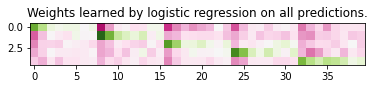

In [92]:
plt.imshow(logistic._logistic_regressor.weights[0].numpy().T, cmap="PiYG", norm=mpl.colors.CenteredNorm())
_ = plt.title("Weights learned by logistic regression on all predictions.")

In [93]:
ensemble_ranking = sorted(ensemble_scores, key=lambda k:ensemble_scores[k], reverse=True)

print("Ranking:")
for rank, (n, ensemble_type) in enumerate(ensemble_ranking):
  print(f"{rank}. acc={ensemble_scores[(n, ensemble_type)]:.4f}, {ensemble_type} ensemble of best {n} models.")

Ranking:
0. acc=0.9895, soft ensemble of best 2 models.
1. acc=0.9895, logistic ensemble of best 7 models.
2. acc=0.9895, logistic ensemble of best 5 models.
3. acc=0.9894, logistic ensemble of best 6 models.
4. acc=0.9894, logistic ensemble of best 8 models.
5. acc=0.9893, logistic ensemble of best 3 models.
6. acc=0.9892, logistic ensemble of best 2 models.
7. acc=0.9892, logistic ensemble of best 4 models.
8. acc=0.9887, soft ensemble of best 3 models.
9. acc=0.9880, soft ensemble of best 5 models.
10. acc=0.9879, hard ensemble of best 3 models.
11. acc=0.9879, soft ensemble of best 4 models.
12. acc=0.9873, hard ensemble of best 5 models.
13. acc=0.9872, soft ensemble of best 6 models.
14. acc=0.9870, hard ensemble of best 4 models.
15. acc=0.9869, hard ensemble of best 2 models.
16. acc=0.9865, soft ensemble of best 7 models.
17. acc=0.9863, hard ensemble of best 7 models.
18. acc=0.9862, hard ensemble of best 6 models.
19. acc=0.9858, soft ensemble of best 8 models.
20. acc=0.984

# Dataset 2: The PTB Diagnostic ECG Database

In this section we solve task 1, 2, 3, and 4 on the "The PTB Diagnostic ECG Database" Dataset.

In [36]:
df_1 = pd.read_csv("data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]
X_masked = replace_zero_padding(X)

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]
X_test_masked = replace_zero_padding(X_test)

In [37]:
def evaluate_model_dataset2(model, test_data=X_test, plot=True):
  pred_test = model.predict(test_data)
  pred_test_binary = (pred_test>0.5).astype(np.int8)

  f1 = f1_score(Y_test, pred_test_binary)

  print("Test f1 score : %s "% f1)

  acc = accuracy_score(Y_test, pred_test_binary)

  print("Test accuracy score : %s "% acc)

  auroc = roc_auc_score(Y_test, pred_test)

  if plot:
    fpr, tpr, _ = roc_curve(Y_test, pred_test)
    viz = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auroc)
    viz.plot()

  print("Test AUROC score : %s "% auroc)

  auprc = average_precision_score(Y_test, pred_test)
  if plot:
    precision, recall, _ = precision_recall_curve(Y_test, pred_test)
    viz = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=auprc)
    viz.plot()

  print("Test AUPRC score : %s "% auprc)

  return (acc, auroc, auprc)

## Data exploration

Plot the histogram of the length of the sequences.

Text(0.5, 1.0, 'Sequence lengths')

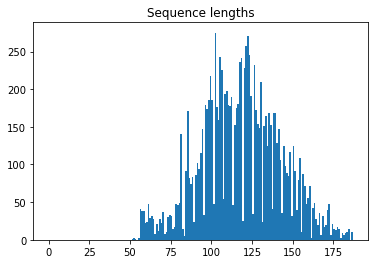

In [38]:
def signal_lengths(X):
  indexes = np.arange(X.shape[1])
  lengths = []
  for sample in X:
    seq_length = np.count_nonzero(sample != PADDING_VALUE)
    # print(seq_length)
    lengths.append(seq_length)
  return lengths

plt.hist(signal_lengths(X_masked), bins=np.arange(188))
plt.title("Sequence lengths")

Plot the distribution of the labels.

Text(0.5, 1.0, 'Label frequencey in the training set')

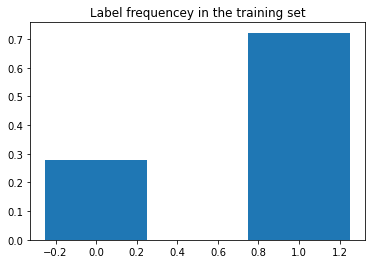

In [39]:
plt.hist(Y, bins=np.arange(3)-0.5, rwidth=0.5, density=True)
plt.title("Label frequencey in the training set")

Plot a sample of sequences.

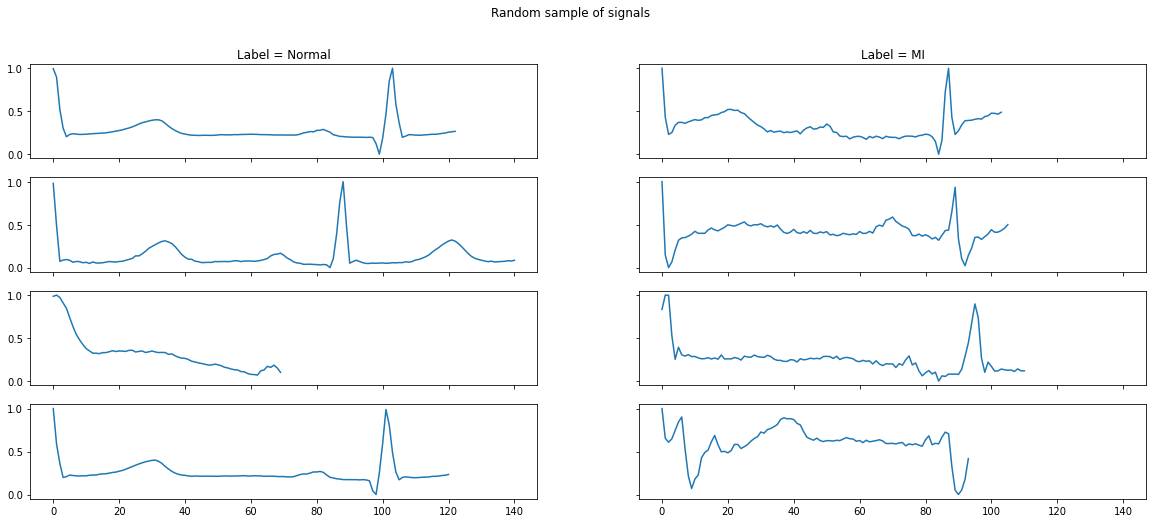

In [40]:
label_to_kw = ["Normal", "MI"]
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(20,8))
fig.suptitle("Random sample of signals")
for i, row in enumerate(axes):
  for label, ax in enumerate(row):
    sample_idx = np.random.choice(np.flatnonzero(Y == label))
    sample = X_masked[sample_idx, :, 0]
    sample = sample[sample != PADDING_VALUE]
    ax.plot(sample)
    if i == 0:
      ax.set_title(f"Label = {label_to_kw[Y[sample_idx]]}")

## Baseline model

Initialize the model.

In [41]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate

def get_baseline_ptbdb():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    return model

baseline_ptbdb = get_baseline_ptbdb()
baseline_ptbdb.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_418 (Conv1D)          (None, 183, 16)           96        
_________________________________________________________________
conv1d_419 (Conv1D)          (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 89, 16)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 89, 16)            0         
_________________________________________________________________
conv1d_420 (Conv1D)          (None, 87, 32)            1568      
_________________________________________________________________
conv1d_421 (Conv1D)          (None, 85, 32)            3104

Train the model.

In [42]:
file_path = os.path.join("saved_weights", "baseline_cnn_ptbdb.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

if ALLOW_TRAINING:
  baseline_ptbdb.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
else:
  print("Training disabled.")
baseline_ptbdb.load_weights(file_path)

Training disabled.


Evaluate the model.

Test f1 score : 0.9858156028368794 
Test accuracy score : 0.979388526279629 
Test AUROC score : 0.9963558162865668 
Test AUPRC score : 0.9980825531873503 


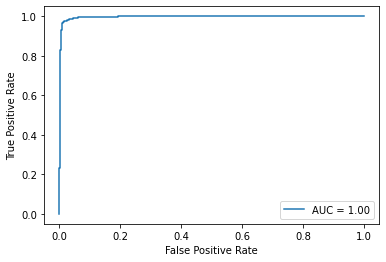

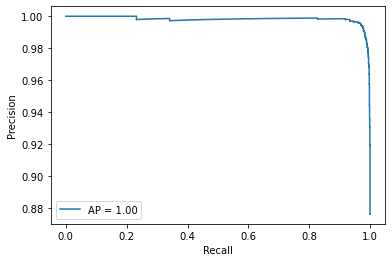

In [43]:
_ = evaluate_model_dataset2(baseline_ptbdb, test_data=X_test)

## Task 1: Vanilla models

### Vanilla MLP

This baseline is simpler than the one we received and better displays the difficulty of the problem.

In [44]:
simple_baseline_ptbdb = tf.keras.Sequential([tf.keras.layers.Input(shape=(187,1)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256, activation="relu"),
                             tf.keras.layers.Dense(1, activation="sigmoid")
                            ])

opt = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.binary_crossentropy
simple_baseline_ptbdb.compile(optimizer=opt,loss=loss,metrics='acc')
simple_baseline_ptbdb.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 187)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               48128     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 48,385
Trainable params: 48,385
Non-trainable params: 0
_________________________________________________________________


In [45]:
file_path = os.path.join("saved_weights", "simple_baseline_ptbdb.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=50, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=30, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

if ALLOW_TRAINING:
  simple_baseline_ptbdb.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
else:
  print("Training disabled.")
simple_baseline_ptbdb.load_weights(file_path)

Training disabled.


Test f1 score : 0.9813931297709922 
Test accuracy score : 0.9732050841635177 
Test AUROC score : 0.9901882838052876 
Test AUPRC score : 0.9948088327357911 


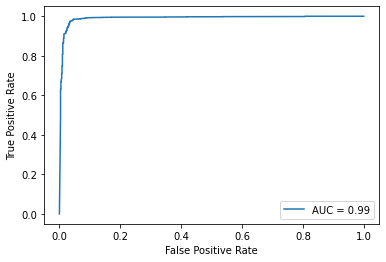

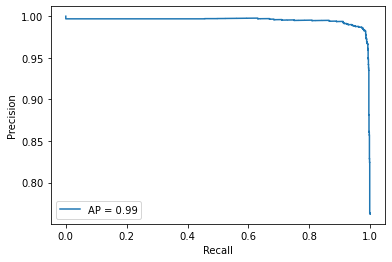

In [46]:
_ = evaluate_model_dataset2(simple_baseline_ptbdb, test_data=X_test)

### Vanilla CNN

Initialize the model.

In [47]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, AvgPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate

# Takes about 4 Hours

def vanilla_CNN_ptbdb(hp):
    nclass = 1
    inp = Input(shape=(187, 1))
    hp_kernel1 = hp.Int('kernel1', min_value=5, max_value=7,step=2)
    img_1 = Convolution1D(16, kernel_size=hp_kernel1, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=hp_kernel1, activation=activations.relu, padding="valid")(img_1)
    hp_pooling1 = hp.Choice('pooling1', ['max'])
    if hp_pooling1 == 'max':
      img_1 = MaxPool1D(pool_size=2,data_format='channels_first')(img_1)
    else:
      img_1 = AvgPool1D(pool_size=2,data_format='channels_first')(img_1)
    hp_dropout1 = hp.Float('dropout1', min_value=0, max_value=0.2, step = 0.1)
    img_1 = Dropout(rate=hp_dropout1)(img_1)
    hp_kernel2 = hp.Int('kernel2', min_value=3, max_value=5,step=2)
    hp_dropout2 = hp.Float('dropout2', min_value=0, max_value=0.2, step = 0.1)
    hp_nlayers = hp.Int('num_layers', 0, 2)
    hp_pooling2 = hp.Choice('pooling2', ['max'])
    
    for i in range(hp_nlayers):

        img_1 = Convolution1D((i+1)*32, kernel_size=hp_kernel2, activation=activations.relu, padding="valid")(img_1)
        img_1 = Convolution1D((i+1)*32, kernel_size=hp_kernel2, activation=activations.relu, padding="valid")(img_1)
        tf.shape(img_1)
        if hp_pooling2 == 'max':
          img_1 = MaxPool1D(pool_size=2,data_format='channels_first')(img_1)
          tf.shape(img_1)
        else:
          img_1 = AvgPool1D(pool_size=2,data_format='channels_first')(img_1)

        img_1 = Dropout(rate=hp_dropout2)(img_1)

    img_1 = Convolution1D(32*(1+hp_nlayers), kernel_size=hp_kernel2, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32*(1+hp_nlayers), kernel_size=hp_kernel2, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    hp_dropout3 = hp.Float('dropout3', min_value=0, max_value=0.2, step=0.1)
    img_1 = Dropout(rate=hp_dropout3)(img_1)


    hp_dense1 = hp.Int('dense1', min_value=128, max_value=512, step=64)
    hp_dense2 = hp.Int('dense2', min_value=32, max_value=256, step=32)
    dense_1 = Dense(hp_dense1, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(hp_dense2, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3,1e-4])
    opt = optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    return model

    
tuner = kt.tuners.bayesian.BayesianOptimization(vanilla_CNN_ptbdb,
                     objective='val_acc',
                     seed=1,
                     num_initial_points = 5,
                     max_trials=75,
                     overwrite=True
                     )




if ALLOW_TRAINING:
  stop_early = EarlyStopping(monitor='val_acc', patience=5,mode='max',verbose=1)
  tuner.search(X, Y, epochs=50, validation_split=0.1, callbacks=[stop_early])
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
else:
  print("Training disabled.")
  print("Best hyperparameters obtained by previous run.")
  best_hps = kt.HyperParameters()
  best_hps.Fixed("kernel1", 7)
  best_hps.Fixed("pooling1", "max")
  best_hps.Fixed("dropout1", 0)
  best_hps.Fixed("kernel2", 5)
  best_hps.Fixed("dropout2", 0.2)
  best_hps.Fixed("num_layers", 0)
  best_hps.Fixed("pooling2", "max")
  best_hps.Fixed("dropout3", 0.2)
  best_hps.Fixed("dense1", 128)
  best_hps.Fixed("dense2", 32)
  best_hps.Fixed("learning_rate", 1e-3)

print(f"""
The hyperparameter search is complete. The optimal kernel sizes are:
{best_hps.get('kernel1')}, {best_hps.get('kernel2')}
The optimal rate of dropout are: 
{best_hps.get('dropout1')}, {best_hps.get('dropout2')}, {best_hps.get('dropout3')}
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
We use the following Poolings:
{best_hps.get('pooling1')}, {best_hps.get('pooling2')}
The dense layers have the following optimal sizes:
{best_hps.get('dense1')}, {best_hps.get('dense2')}
We use {best_hps.get('num_layers')} + 1 convolutional layers.
""")

Training disabled.
Best hyperparameters obtained by previous run.

The hyperparameter search is complete. The optimal kernel sizes are:
7, 5
The optimal rate of dropout are: 
0, 0.2, 0.2
The optimal learning rate for the optimizer is 0.001.
We use the following Poolings:
max, max
The dense layers have the following optimal sizes:
128, 32
We use 0 + 1 convolutional layers.



Train the model.

In [48]:
vanilla_CNN_ptbdb = tuner.hypermodel.build(best_hps)
vanilla_CNN_ptbdb.summary()

file_path = os.path.join("saved_weights", "vanilla_cnn_ptbdb.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
callbacks_list = [checkpoint, early]  # early

if ALLOW_TRAINING:
  vanilla_CNN_ptbdb.fit(X, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1)
else:
  print("Training disabled.")
vanilla_CNN_ptbdb.load_weights(file_path)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 181, 16)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 175, 16)           1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 175, 8)            0         
_________________________________________________________________
dropout (Dropout)            (None, 175, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 171, 32)           1312      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 167, 32)           5152  

Evaluate the model.

Test f1 score : 0.9869884078542702 
Test accuracy score : 0.9811061490896599 
Test AUROC score : 0.9983075745155299 
Test AUPRC score : 0.9993530273342702 


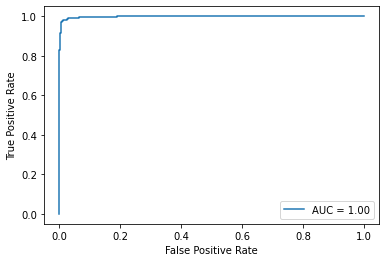

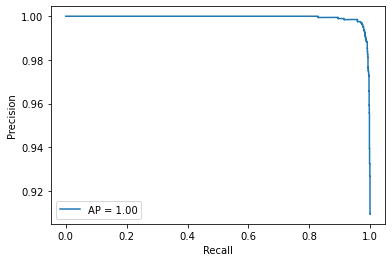

In [49]:
_ = evaluate_model_dataset2(vanilla_CNN_ptbdb, test_data=X_test)

### Vanilla RNN

Initialize the model.

In [50]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, AvgPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from tensorflow.keras.layers import SimpleRNN, LSTM, Masking, Bidirectional

def get_vanilla_RNN_ptbdb():
    nclass = 1
    inp = Input(shape=(187, 1))
    masked = Masking(mask_value=-1)(inp)
    hidden_1 = SimpleRNN(64)(masked)

    dense_1 = Dense(512, activation=activations.relu, name="dense_1")(hidden_1)
    dense_1 = Dropout(rate=0.1)(dense_1)
    dense_1 = Dense(128, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dropout(rate=0.1)(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    return model

vanilla_RNN_ptbdb = get_vanilla_RNN_ptbdb()
vanilla_RNN_ptbdb.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
masking (Masking)            (None, 187, 1)            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0   

Train the model.

In [51]:
file_path = os.path.join("saved_weights", "vanilla_rnn_ptbdb.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
callbacks_list = [checkpoint, early]  # early


if ALLOW_TRAINING:
  vanilla_RNN_ptbdb.fit(X_masked, Y, epochs=1000, verbose=1, callbacks=[callbacks_list], validation_split=0.1)
else:
  print("Training disabled.")
vanilla_RNN_ptbdb.load_weights(file_path)

Training disabled.


Evaluate the model.

Test f1 score : 0.9398802395209581 
Test accuracy score : 0.9137753349364479 
Test AUROC score : 0.9631823950114025 
Test AUPRC score : 0.9828493275222259 


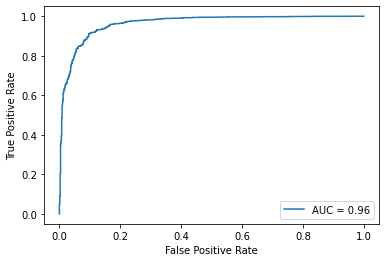

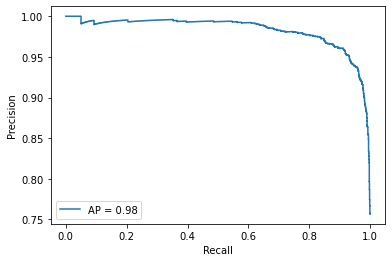

In [52]:
_ = evaluate_model_dataset2(vanilla_RNN_ptbdb, test_data=X_test_masked)

## Task 2: Creative models

### Fourier transform based model

In [53]:
def to_fourier(X):  
  outputs = []
  for x in tqdm(X[:,:,0]):
    x = x.copy()
    x[x == PADDING_VALUE] = 0.5 # set a value which should be near the mean
    transformed = tf.signal.rfft(x).numpy()
    real_imag = np.stack([np.real(transformed),
                          np.imag(transformed),
                          ]).T
    outputs.append(real_imag)
  print() # tqdm doesn't do a new line
  return np.stack(outputs)

X_fourier = to_fourier(X)
X_test_fourier = to_fourier(X_test)

  7%|███████▏                                                                                         | 214/2911 [00:00<00:01, 2124.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2911/2911 [00:01<00:00, 2059.84it/s]

In [54]:
def get_baseline_ptbdb_fourier():
    nclass = 1
    inp = tf.keras.layers.Input(shape=(X_fourier.shape[1], X_fourier.shape[2]))
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=tf.keras.activations.relu, padding="valid")(inp)
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    img_1 = tf.keras.layers.Convolution1D(256, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.Convolution1D(256, kernel_size=3, activation=tf.keras.activations.relu, padding="valid")(img_1)
    img_1 = tf.keras.layers.GlobalMaxPool1D()(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.2)(img_1)

    dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, name="dense_1")(img_1)
    dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, name="dense_2")(dense_1)
    dense_1 = tf.keras.layers.Dense(nclass, activation=tf.keras.activations.sigmoid, name="dense_3_mitbih")(dense_1)

    model = tf.keras.models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])
    return model

baseline_ptbdb_fourier = get_baseline_ptbdb_fourier()
baseline_ptbdb_fourier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 94, 2)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 90, 16)            176       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 86, 16)            1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 16)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 43, 16)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 41, 32)            1568      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 39, 32)            3104

In [55]:
file_path = os.path.join("saved_weights", "baseline_with_fourier_ptbdb.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

if ALLOW_TRAINING:
  baseline_ptbdb_fourier.fit(X_fourier, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
else:
  print("Training disabled.")
baseline_ptbdb_fourier.load_weights(file_path)

Training disabled.


Test f1 score : 0.9902682174222643 
Test accuracy score : 0.9859154929577465 
Test AUROC score : 0.9959923976106103 
Test AUPRC score : 0.9969959442123186 


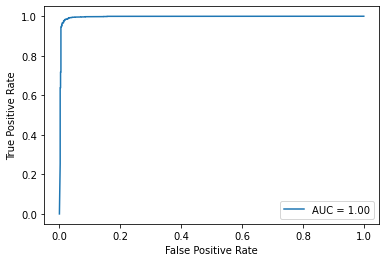

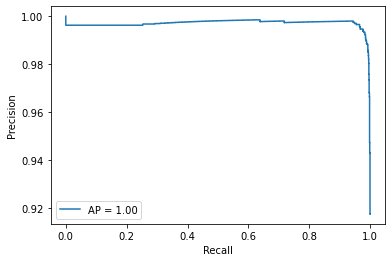

In [56]:
_ = evaluate_model_dataset2(baseline_ptbdb_fourier, test_data=X_test_fourier)

### CNN with Residual Blocks (aka Resnet)

The code in the following cell is adapted from ResNet V2's [github repository](https://github.com/KaimingHe/resnet-1k-layers).

In [57]:
def get_residual_unit(output_filters, stride):
  def residual_unit(inputs):
    n_bottleneck = output_filters // 4

    # conv 1x1
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.ReLU()(x)

    if inputs.shape[-1] == output_filters:
      shortcut = inputs
    else:
      shortcut = tf.keras.layers.Conv1D(output_filters, 1, stride, "same")(x)

    x = tf.keras.layers.Conv1D(n_bottleneck, 1, stride, "same")(x)

    # conv 3x3
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(n_bottleneck, 3, 1, "same")(x)

    # conv 1x1
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(output_filters, 1, 1, "same")(x)

    x = tf.keras.layers.Add()([shortcut, x])

    return x

  return residual_unit

def get_resnet_stage(output_filters, count, stride, name):
  def resnet_stage(inputs):
    x = get_residual_unit(output_filters, stride)(inputs)

    for i in range(count - 1):
      x = get_residual_unit(output_filters, 1)(x)
    
    return x

  return resnet_stage

def get_resnet(depth):
  assert (depth - 2) % 9 == 0
  n = (depth - 2) // 9

  stage_filters = [16, 64, 128, 256]

  # Stage 0
  inputs = tf.keras.layers.Input(shape=(187, 1))
  x = tf.keras.layers.Conv1D(stage_filters[0], 7, 1, "same")(inputs)
  x = get_resnet_stage(stage_filters[1], n, 1, "stage_1")(x)
  x = get_resnet_stage(stage_filters[2], n, 2, "stage_2")(x)
  x = get_resnet_stage(stage_filters[3], n, 2, "stage_3")(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  opt = tf.keras.optimizers.Adam(0.001)
  loss = tf.keras.losses.BinaryCrossentropy()

  model.compile(optimizer=opt,loss=loss,metrics='acc')
  return model


resnet_ptbdb = get_resnet(101)
resnet_ptbdb.summary()
# tf.keras.utils.plot_model(resnet, show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 187, 16)      128         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 187, 16)      64          conv1d_12[0][0]                  
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 187, 16)      0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [58]:
# We use the masked dataset because we used it during training by mistake
file_path = os.path.join("saved_weights", "resnet_ptbdb.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

if ALLOW_TRAINING:
  resnet_ptbdb.fit(X_masked, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1, batch_size=128)
else:
  print("Training disabled.")
resnet_ptbdb.load_weights(file_path)

Training disabled.


Test f1 score : 0.9940688018979834 
Test accuracy score : 0.9914118859498454 
Test AUROC score : 0.9986492351154178 
Test AUPRC score : 0.9993119726740534 


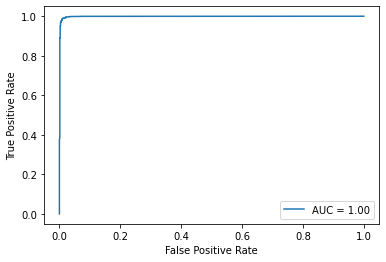

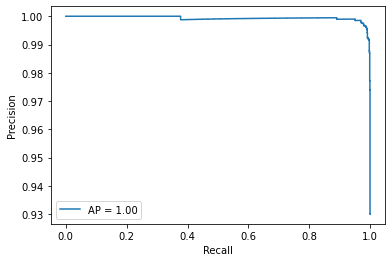

In [59]:
_ = evaluate_model_dataset2(resnet_ptbdb, test_data=X_test_masked)

### Bidirectional LSTM

In [60]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, AvgPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from tensorflow.keras.layers import SimpleRNN, LSTM, Masking, Bidirectional

def get_bidirectional_lstm_ptbdb():
    nclass = 1
    inp = Input(shape=(187, 1))
    masked = Masking(mask_value=PADDING_VALUE)(inp)
    hidden_1 = Bidirectional(LSTM(128))(masked)

    dense_1 = Dense(256, activation=activations.relu)(hidden_1)
    dense_1 = Dropout(rate=0.1)(dense_1)
    dense_1 = Dense(128, activation=activations.relu)(dense_1)
    dense_1 = Dropout(rate=0.1)(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    return model

bidirectional_lstm_ptbdb = get_bidirectional_lstm_ptbdb()
bidirectional_lstm_ptbdb.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
masking_1 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               133120    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0   

In [61]:
file_path = os.path.join("saved_weights", "bidirectional_lstm_ptbdb.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early


if ALLOW_TRAINING:
  bidirectional_lstm_ptbdb.fit(X_masked, Y, epochs=1000, verbose=1, callbacks=[callbacks_list], validation_split=0.1)
else:
  print("Training disabled.")
bidirectional_lstm_ptbdb.load_weights(file_path)

Training disabled.


Test f1 score : 0.9093504639543183 
Test accuracy score : 0.8691171418756442 
Test AUROC score : 0.9336772677501797 
Test AUPRC score : 0.9726792343661873 


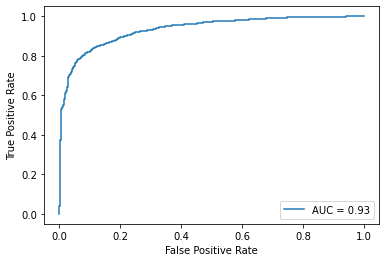

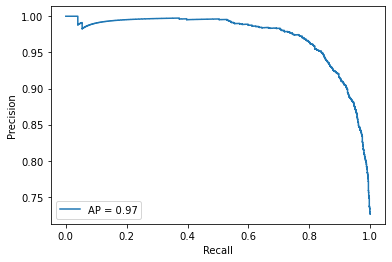

In [62]:
_ = evaluate_model_dataset2(bidirectional_lstm_ptbdb, test_data=X_test_masked)

### CNN + Bidirectional LSTM Model 

In [63]:
def get_cnn_bi_lstm_ptbdb():
    nclass = 1
    inp = tf.keras.layers.Input(shape=(187, 1))

    conv = tf.keras.layers.Conv1D(filters=200, kernel_size=3, dilation_rate=2, activation="relu")(inp)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(rate=0.1)(conv)

    conv = tf.keras.layers.Conv1D(filters=150, kernel_size=3, dilation_rate=2, activation="relu")(conv)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(rate=0.1)(conv)

    conv = tf.keras.layers.Conv1D(filters=100, kernel_size=3, dilation_rate=2, activation="relu")(conv)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(rate=0.1)(conv)

    conv = tf.keras.layers.Conv1D(filters=75, kernel_size=3, dilation_rate=2, activation="relu")(conv)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(rate=0.1)(conv)


    hidden_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True))(conv)

    dense_1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(hidden_1)
    dense_1 = tf.keras.layers.Dropout(rate=0.3)(dense_1)
    dense_1 = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)(dense_1)
    dense_1 = tf.keras.layers.Dropout(rate=0.3)(dense_1)
    dense_1 = tf.keras.layers.Flatten()(dense_1)
    dense_1 = tf.keras.layers.Dense(nclass, activation=tf.keras.activations.sigmoid)(dense_1)

    model = tf.keras.models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(optimizer=opt, loss=focal_loss.BinaryFocalLoss(gamma=1.5), metrics=["acc"])



    return model

cnn_bi_lstm_ptbdb = get_cnn_bi_lstm_ptbdb()
cnn_bi_lstm_ptbdb.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 183, 200)          800       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 91, 200)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 91, 200)           0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 87, 150)           90150     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 43, 150)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 43, 150)           0   

In [64]:
file_path = os.path.join("saved_weights", "cnn_bi_lstm_ptbdb.h5")
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=7, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_acc", mode="max", patience=3, verbose=2)

callbacks_list = [early,redonplat]  # early

if ALLOW_TRAINING:
  cnn_bi_lstm_ptbdb.fit(X_masked, Y, epochs=1000, verbose=1, callbacks=[callbacks_list], validation_split=0.1, shuffle=True)
  cnn_bi_lstm_ptbdb.save(file_path)
else:
  print("Training disabled.")
cnn_bi_lstm_ptbdb.load_weights(file_path)

Training disabled.


Test f1 score : 0.9940546967895363 
Test accuracy score : 0.9914118859498454 
Test AUROC score : 0.9962864256655912 
Test AUPRC score : 0.9962328227539421 


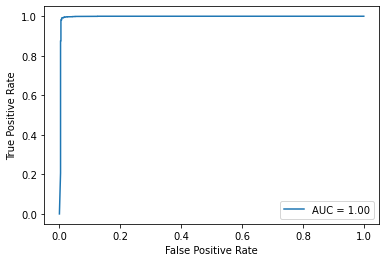

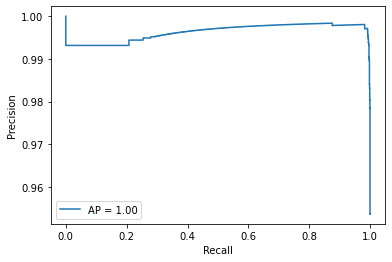

In [65]:
_ = evaluate_model_dataset2(cnn_bi_lstm_ptbdb, test_data=X_test_masked)

## Task 4: Transfer Learning

### Frozen Base

In [66]:
def transfer_learning_frozen_base(base_model, remove_layers = 1, add_layers = 1, neurons_1 = 256, neurons_2 = 128, lr = 1e-3):
  weights = base_model.get_weights()
  base_model = tf.keras.models.clone_model(base_model)
  base_model.set_weights(weights)
  base_model.trainable = False

  dense_1 = base_model.layers[-(remove_layers+1)].output 
  if add_layers == 3:
    dense_2 = Dense(neurons_1, activation=activations.relu, name="dense__1")(dense_1)
    dense_3 = Dense(neurons_2, activation=activations.relu, name="dense__2")(dense_2)
    output = Dense(1, activation=activations.sigmoid, name="dense__3")(dense_3)
  elif add_layers == 2: 
    dense_2 = Dense(neurons_1, activation=activations.relu, name="dense__1")(dense_1)
    output = Dense(1, activation=activations.sigmoid, name="dense__3")(dense_2)
  elif add_layers == 1:
    output = Dense(1, activation=activations.sigmoid, name="dense__3")(dense_1)
  else:
    print("Value of remove_layers not defined yet. Please adapt function or choose value in [1,3]")
  
  model = tf.keras.Model(inputs = base_model.input, outputs = output)
  model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=losses.binary_crossentropy, metrics=['acc'])
  return model

tl_model_frozen_base = transfer_learning_frozen_base(baseline_mitbih, remove_layers=3, add_layers=3)
tl_model_frozen_base.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 16)           96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 89, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 87, 32)            1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 85, 32)            3104

In [67]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',np.unique(Y),Y)
class_weight_dict = dict(enumerate(class_weights))

file_path = os.path.join("saved_weights", "transfer_learning_frozen_base.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [early,redonplat,checkpoint] 

if ALLOW_TRAINING:
  tl_model_frozen_base.fit(X, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1, class_weight=class_weight_dict)
else:
  print("Training disabled.")
tl_model_frozen_base.load_weights(file_path)

Training disabled.


C:\Users\sgreg\Anaconda3\envs\ml4h-p4\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Test f1 score : 0.977960765318479 
Test accuracy score : 0.9687392648574373 
Test AUROC score : 0.9957589393349556 
Test AUPRC score : 0.9980968760951845 


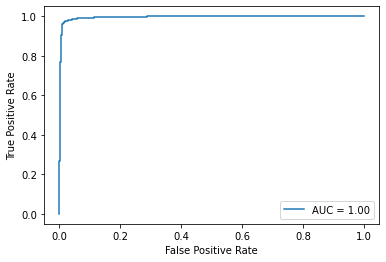

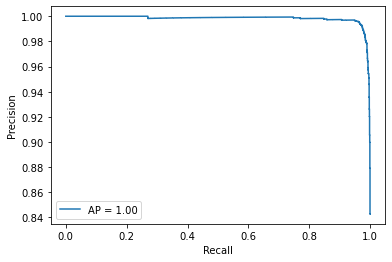

In [68]:
_ = evaluate_model_dataset2(tl_model_frozen_base, test_data=X_test)

### Retrain the whole model

In [69]:
def transfer_learning_retraining_base(base_model, remove_layers = 1, add_layers = 1, neurons_1 = 256, neurons_2 = 128, lr = 1e-3):
  weights = base_model.get_weights()
  base_model = tf.keras.models.clone_model(base_model)
  base_model.set_weights(weights)
  base_model.trainable = True

  dense_1 = base_model.layers[-(remove_layers+1)].output 
  if add_layers == 3:
    dense_2 = Dense(neurons_1, activation=activations.relu, name="dense__1")(dense_1)
    dense_3 = Dense(neurons_2, activation=activations.relu, name="dense__2")(dense_2)
    output = Dense(1, activation=activations.sigmoid, name="dense__3")(dense_3)
  elif add_layers == 2: 
    dense_2 = Dense(neurons_1, activation=activations.relu, name="dense__1")(dense_1)
    output = Dense(1, activation=activations.sigmoid, name="dense__3")(dense_2)
  elif add_layers == 1:
    output = Dense(1, activation=activations.sigmoid, name="dense__3")(dense_1)
  else:
    print("Value of remove_layers not defined yet. Please adapt function or choose value in [1,3]")
  
  model = tf.keras.Model(inputs = base_model.input, outputs = output)
  model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=losses.binary_crossentropy, metrics=['acc'])
  return model

tl_model_retrain = transfer_learning_retraining_base(resnet)
tl_model_retrain.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 187, 16)      128         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 187, 16)      64          conv1d_14[0][0]                  
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 187, 16)      0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [70]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',np.unique(Y),Y)
class_weight_dict = dict(enumerate(class_weights))

file_path = os.path.join("saved_weights", "transfer_learning_retrained.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [early,redonplat,checkpoint] 

if ALLOW_TRAINING:
  tl_model_retrain.fit(X_masked, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1, class_weight=class_weight_dict)
else:
  print("Training disabled.")
tl_model_retrain.load_weights(file_path)

Training disabled.


C:\Users\sgreg\Anaconda3\envs\ml4h-p4\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Test f1 score : 0.9971442170395051 
Test accuracy score : 0.9958777052559258 
Test AUROC score : 0.9993825410845402 
Test AUPRC score : 0.999695653993875 


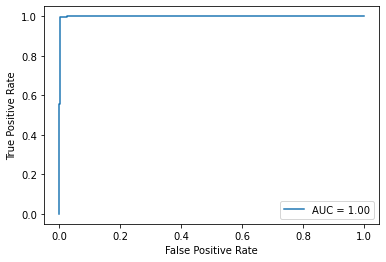

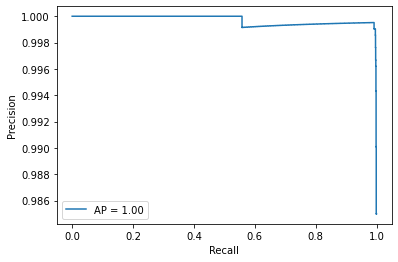

In [71]:
_ = evaluate_model_dataset2(tl_model_retrain, test_data=X_test_masked)

## Task 3: Ensemble models

In [76]:
train_test_sets = {
    "normal": (X, X_test),
    "masked": (X_masked, X_test_masked),
    "fourier": (X_fourier, X_test_fourier)}
all_models = {
    "Baseline": (baseline_ptbdb, "normal"),
    "Vanilla MLP": (simple_baseline_ptbdb, "normal"),
    "Vanilla CNN": (vanilla_CNN_ptbdb, "normal"),
    "Vanilla RNN": (vanilla_RNN_ptbdb, "masked"),
    "Baseline with DFT": (baseline_ptbdb_fourier, "fourier"),
    "Bidirectional LSTM": (bidirectional_lstm_ptbdb, "masked"),
    "101-layer ResNet V2": (resnet_ptbdb, "masked"),
    "Bidirectional LSTM with CNN": (cnn_bi_lstm_ptbdb, "masked"),
    "TL with frozen Baseline Mitbh": (tl_model_frozen_base, "normal"),
    "TL with retrained Resnet Mitbh": (tl_model_retrain, "masked")}

scores = {}
for model_name, (model, dataset_type) in all_models.items():
  print(f'Scores for model "{model_name}":')
  _, test_data = train_test_sets[dataset_type]
  scores[model_name] = evaluate_model_dataset2(model, test_data, plot=False)
  print()

Scores for model "Baseline":
Test f1 score : 0.9858156028368794 
Test accuracy score : 0.979388526279629 
Test AUROC score : 0.9963558162865668 
Test AUPRC score : 0.9980825531873503 

Scores for model "Vanilla MLP":
Test f1 score : 0.9813931297709922 
Test accuracy score : 0.9732050841635177 
Test AUROC score : 0.9901882838052876 
Test AUPRC score : 0.9948088327357911 

Scores for model "Vanilla CNN":
Test f1 score : 0.9869884078542702 
Test accuracy score : 0.9811061490896599 
Test AUROC score : 0.9983075745155299 
Test AUPRC score : 0.9993530273342702 

Scores for model "Vanilla RNN":
Test f1 score : 0.9398802395209581 
Test accuracy score : 0.9137753349364479 
Test AUROC score : 0.9631823950114025 
Test AUPRC score : 0.9828493275222259 

Scores for model "Baseline with DFT":
Test f1 score : 0.9902682174222643 
Test accuracy score : 0.9859154929577465 
Test AUROC score : 0.9959923976106103 
Test AUPRC score : 0.9969959442123186 

Scores for model "Bidirectional LSTM":
Test f1 score 

In [77]:
def get_ranking(scores, idx, full_name, short_name):
  ranking = sorted(scores, key=lambda k:scores[k][idx], reverse=True)

  print(f"Ranking for {full_name}:")
  for rank, model_name in enumerate(ranking):
    print(f"{rank}. {short_name}={scores[model_name][idx]:.5f}, {model_name}")
  print()
  return ranking

ranking_acc = get_ranking(scores, 0, "accuracy", "acc")
ranking_auroc = get_ranking(scores, 1, "AUROC", "auroc")
ranking_auprc = get_ranking(scores, 2, "AUPRC", "auprc")

Ranking for accuracy:
0. acc=0.99588, TL with retrained Resnet Mitbh
1. acc=0.99141, 101-layer ResNet V2
2. acc=0.99141, Bidirectional LSTM with CNN
3. acc=0.98592, Baseline with DFT
4. acc=0.98111, Vanilla CNN
5. acc=0.97939, Baseline
6. acc=0.97321, Vanilla MLP
7. acc=0.96874, TL with frozen Baseline Mitbh
8. acc=0.91378, Vanilla RNN
9. acc=0.86912, Bidirectional LSTM

Ranking for AUROC:
0. auroc=0.99938, TL with retrained Resnet Mitbh
1. auroc=0.99865, 101-layer ResNet V2
2. auroc=0.99831, Vanilla CNN
3. auroc=0.99636, Baseline
4. auroc=0.99629, Bidirectional LSTM with CNN
5. auroc=0.99599, Baseline with DFT
6. auroc=0.99576, TL with frozen Baseline Mitbh
7. auroc=0.99019, Vanilla MLP
8. auroc=0.96318, Vanilla RNN
9. auroc=0.93368, Bidirectional LSTM

Ranking for AUPRC:
0. auprc=0.99970, TL with retrained Resnet Mitbh
1. auprc=0.99935, Vanilla CNN
2. auprc=0.99931, 101-layer ResNet V2
3. auprc=0.99810, TL with frozen Baseline Mitbh
4. auprc=0.99808, Baseline
5. auprc=0.99700, Baseli

In [78]:
chosen_ranking = ranking_auprc

def get_ensemble_data(model_names):
  models, Xs, Xs_test = [], [], []
  for model_name in model_names:
    model, dataset_type = all_models[model_name]
    models.append(model)
    X, X_test = train_test_sets[dataset_type]
    Xs.append(X)
    Xs_test.append(X_test)
  return models, Xs, Xs_test

ensemble_scores = {}
for n_models in range(2, len(all_models)+1):
  model_names = chosen_ranking[:n_models]
  models, Xs, Xs_test = get_ensemble_data(model_names)

  print(f"Ensemble of top {n_models} models:")
  print(f"-Soft Voting")
  soft = VotingEnsemble(models)
  metrics = evaluate_model_dataset2(soft, test_data=Xs_test, plot=False)
  ensemble_scores[(n_models, "soft")] = metrics

  print(f"-Hard Voting")
  hard = VotingEnsemble(models, voting="hard")
  metrics = evaluate_model_dataset2(hard, test_data=Xs_test, plot=False)
  ensemble_scores[(n_models, "hard")] = metrics

  print(f"-Logistic regression on predictions:")
  logistic = LogisticEnsemble(models)
  logistic.fit(Xs, Y)
  metrics = evaluate_model_dataset2(logistic, test_data=Xs_test, plot=False)
  ensemble_scores[(n_models, "logistic")] = metrics
  print()

Ensemble of top 2 models:
-Soft Voting
Test f1 score : 0.9969113803753862 
Test accuracy score : 0.9955341806939196 
Test AUROC score : 0.9996212918651846 
Test AUPRC score : 0.999848602933106 
-Hard Voting
Test f1 score : 0.9945068067828995 
Test accuracy score : 0.9920989350738578 
Test AUROC score : 0.9971937962432624 
Test AUPRC score : 0.9980232547574662 
-Logistic regression on predictions:
Epoch 1/1000
328/328 - 1s - loss: 0.5549 - acc: 0.7221 - val_loss: 0.4922 - val_acc: 0.6970

Epoch 00001: val_acc improved from -inf to 0.69700, saving model to saved_weights\ensemble_lr.h5
Epoch 2/1000
328/328 - 1s - loss: 0.4354 - acc: 0.7235 - val_loss: 0.4182 - val_acc: 0.6961

Epoch 00002: val_acc did not improve from 0.69700
Epoch 3/1000
328/328 - 1s - loss: 0.3731 - acc: 0.7239 - val_loss: 0.3658 - val_acc: 0.6979

Epoch 00003: val_acc improved from 0.69700 to 0.69785, saving model to saved_weights\ensemble_lr.h5
Epoch 4/1000
328/328 - 1s - loss: 0.3243 - acc: 0.7468 - val_loss: 0.3190 

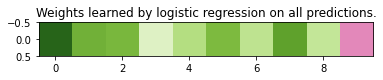

In [79]:
plt.imshow(logistic._logistic_regressor.weights[0].numpy().T, cmap="PiYG", norm=mpl.colors.CenteredNorm())
_ = plt.title("Weights learned by logistic regression on all predictions.")

In [80]:
def get_ensemble_ranking(scores, idx, full_name, short_name):
  ranking = sorted(scores, key=lambda k:scores[k][idx], reverse=True)

  print(f"Ensemble ranking for {full_name}:")
  for rank, (n, ensemble_type) in enumerate(ranking):
    print(f"{rank}. acc={scores[(n, ensemble_type)][idx]:.6f}, {ensemble_type} ensemble of best {n} models (AUPRC).")
  print()
  return ranking

ensemble_ranking_acc = get_ensemble_ranking(ensemble_scores, 0, "accuracy", "acc")
ensemble_ranking_auroc = get_ensemble_ranking(ensemble_scores, 1, "AUROC", "auroc")
ensemble_ranking_auprc = get_ensemble_ranking(ensemble_scores, 2, "AUPRC", "auprc")

Ensemble ranking for accuracy:
0. acc=0.997595, soft ensemble of best 8 models (AUPRC).
1. acc=0.997595, soft ensemble of best 9 models (AUPRC).
2. acc=0.997252, soft ensemble of best 4 models (AUPRC).
3. acc=0.997252, hard ensemble of best 4 models (AUPRC).
4. acc=0.997252, hard ensemble of best 6 models (AUPRC).
5. acc=0.997252, hard ensemble of best 7 models (AUPRC).
6. acc=0.996908, soft ensemble of best 7 models (AUPRC).
7. acc=0.996908, hard ensemble of best 8 models (AUPRC).
8. acc=0.996908, soft ensemble of best 10 models (AUPRC).
9. acc=0.996565, soft ensemble of best 5 models (AUPRC).
10. acc=0.996565, soft ensemble of best 6 models (AUPRC).
11. acc=0.996565, hard ensemble of best 9 models (AUPRC).
12. acc=0.996221, soft ensemble of best 3 models (AUPRC).
13. acc=0.996221, hard ensemble of best 5 models (AUPRC).
14. acc=0.995534, soft ensemble of best 2 models (AUPRC).
15. acc=0.995534, hard ensemble of best 10 models (AUPRC).
16. acc=0.995191, hard ensemble of best 3 models 